<div class="alert alert-block alert-success">
    <h2>Building a Recommender System using Item to Item Collaborative Filtering</h2>
    <p>The objective of this study is to design a recommendation system leveraging the compact MovieLens dataset, encompassing 100,000 ratings. The specific challenge here is the non-usage of Title and Genre information, making it a unique case for a recommendation system.

The dataset has been divided into training and testing subsets in a randomized manner. The training subset constitutes the major portion with 990,206 ratings, while the remainder forms the testing set. The ultimate goal is to construct a Recommender System that is capable of accurately predicting the ratings in the testing set.

Let's start by loading the data.</p>
</div>

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("ratings.dat", sep="::", engine="python", names = ["UserIDs", "MovieIDs", "Ratings", "Timestamp"])
data.drop("Timestamp", axis = 1, inplace = True)
print(data.shape)
data.head()

(1000209, 3)


,UserIDs,MovieIDs,Ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   UserIDs   1000209 non-null  int64
 1   MovieIDs  1000209 non-null  int64
 2   Ratings   1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [4]:
data.nunique()

UserIDs     6040
MovieIDs    3706
Ratings        5
dtype: int64

<div class="alert alert-block alert-info">
    <p>There are 3.706 movies which are rated by 6.040 users. With no missing data and compatible data types, our dataset is well-prepared for the next step in our analysis. We'll proceed by dividing the data into training and testing subsets. This process is crucial for establishing a reliable recommendation system; it allows us to train the model on a substantial portion of the data (the training set) and then assess its predictive performance on unseen data (the testing set).

Let's move forward and segment the dataset, bearing in mind to maintain an appropriate and representative distribution of data within both subsets to ensure the validity and generalizability of our model.</p>
</div>

In [5]:
from sklearn import model_selection as mod
from IPython.display import display

In [6]:
trainFinal, testFinal = mod.train_test_split(data, test_size=0.01)
print(trainFinal.shape)
display(trainFinal.head())
print(testFinal.shape)
display(testFinal.head())

(990206, 3)


,UserIDs,MovieIDs,Ratings
430081,2621,801,1
292263,1741,3659,4
475393,2918,2282,4
26914,192,3868,5
568094,3486,2084,5


(10003, 3)


,UserIDs,MovieIDs,Ratings
82427,547,17,3
60042,409,3100,4
541563,3332,3753,1
352909,2067,3088,3
118166,764,1088,5


Excellent, the next step is to create a pivot table. In the context of collaborative filtering, pivot tables are a handy tool for reshaping the data and making it easier to analyze.

<p>For user-to-user collaborative filtering, we'll structure our pivot table such that both rows and columns represent individual users. The intersecting cells will then contain the rating a particular user (row) has given to a movie reviewed by another user (column).

Please note that this might lead to a very sparse matrix, as not every user will have rated every other user's watched movie. Nevertheless, this setup is a common practice in recommender systems and forms the basis for similarity computation among users.

Let's proceed and construct the pivot table.

In [7]:
piv = trainFinal.pivot_table(index = "MovieIDs", columns = "UserIDs", values = "Ratings")
print(piv.shape)
piv.head()

(3706, 6040)


UserIDs,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieIDs,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Indeed, normalization is an essential step in preparing data for machine learning models. Normalizing the ratings using the mean rating of the movies will help us handle any bias in the data, and allow our model to interpret ratings on a standard scale.

This process will involve calculating the mean rating for each movie and then subtracting that mean from each rating given to the movie. The result will be a data set where positive values indicate a rating above the mean, negative values indicate a rating below the mean, and zero indicates a rating that is exactly the mean.

This form of normalization, often referred to as "mean centering," will help to manage any skewness in the data, as well as ensure that the mean rating for each movie in our normalized data set is zero. This makes it easier for the recommender system to identify and learn patterns in the data.

Let's move forward with the normalization process.

In [8]:
item_mean = piv.mean(axis = 1)

mean_rating = item_mean.values.reshape(-1,1)
mean_rating

array([[4.14605648],
       [3.2       ],
       [3.02335456],
       ...,
       [3.66666667],
       [3.9       ],
       [3.77748691]])

In [9]:
piv_scaled = piv - mean_rating
piv_scaled.head()

UserIDs,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieIDs,,,,,,,,,,,,,,,,,,,,,
1,0.853944,NaN,NaN,NaN,NaN,-0.146056,NaN,-0.146056,0.853944,0.853944,...,NaN,-0.146056,NaN,NaN,-0.146056,NaN,NaN,NaN,NaN,-1.146056
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.023355,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.272189,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.727811,-0.727811,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.000000,NaN,NaN,NaN,NaN,NaN


Once the ratings are normalized with respect to the mean rating of each movie, the NaN values - which were originally due to a user not rating a particular movie - can be substituted with zeros. This is because, after normalization, a rating of zero effectively represents an "average" rating for that movie.

Filling NaN values with zeros in this case will result in a more manageable dataset.

In [10]:
piv_scaled.fillna(0, inplace = True)
piv_scaled.head()

UserIDs,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieIDs,,,,,,,,,,,,,,,,,,,,,
1,0.853944,0.0,0.0,0.0,0.0,-0.146056,0.0,-0.146056,0.853944,0.853944,...,0.0,-0.146056,0.0,0.0,-0.146056,0.000000,0.0,0.0,0.0,-1.146056
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.800000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-2.023355,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.272189,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-0.727811,-0.727811,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-2.000000,0.000000,0.0,0.0,0.0,0.000000


In [11]:
piv_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3706 entries, 1 to 3952
Columns: 6040 entries, 1 to 6040
dtypes: float64(6040)
memory usage: 170.8 MB


Data type conversion from float64 to float32 will reduce the memory footprint of dataset and can potentially speed up computations. Let's proceed and convert the data type of the matrix values to float32 to optimize the computation time.

In [12]:
piv_scaled = piv_scaled.astype("float32")
piv_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3706 entries, 1 to 3952
Columns: 6040 entries, 1 to 6040
dtypes: float32(6040)
memory usage: 85.4 MB


In [13]:
piv_scaled.head()

UserIDs,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieIDs,,,,,,,,,,,,,,,,,,,,,
1,0.853944,0.0,0.0,0.0,0.0,-0.146056,0.0,-0.146056,0.853944,0.853944,...,0.0,-0.146056,0.0,0.0,-0.146056,0.000000,0.0,0.0,0.0,-1.146057
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.800000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-2.023355,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.272189,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-0.727811,-0.727811,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-2.000000,0.000000,0.0,0.0,0.0,0.000000


Now we will create a model to predict ratings. I will divide the data once more to evaluate the performance of the model we have created befor testing on the final test data. We will keep the test size small to improve the training time.

By splitting the data once more, we're effectively creating a validation set. This allows us to evaluate our model's performance during the development process, without touching final testing set until we're ready. The validation set serves as a 'practice ground' for the model, which is especially useful for tuning hyperparameters and making other adjustments.

Keeping the test size small, will speed up training time, though it may limit the model's ability to generalize well to unseen data. However, since the primary goal here is to practice and understand the underlying mechanics of building and refining a recommendation system, this approach is completely justified.

In [14]:
train = piv_scaled[:-20]
test = piv_scaled[-20:]

In [15]:
print(train.shape)
display(train.head())

print(test.shape)
display(test.head())

(3686, 6040)


UserIDs,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieIDs,,,,,,,,,,,,,,,,,,,,,
1,0.853944,0.0,0.0,0.0,0.0,-0.146056,0.0,-0.146056,0.853944,0.853944,...,0.0,-0.146056,0.0,0.0,-0.146056,0.000000,0.0,0.0,0.0,-1.146057
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.800000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-2.023355,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.272189,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-0.727811,-0.727811,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-2.000000,0.000000,0.0,0.0,0.0,0.000000


(20, 6040)


UserIDs,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieIDs,,,,,,,,,,,,,,,,,,,,,
3933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For each movie-user pair in the test set, we will the predicted rating based on the average ratings of the k most similar movies (i.e., nearest neighbors) that the user has rated in the training set. The similarity is computed using cosine similarity, and k is initially set to 20 but adjusted if fewer ratings are available. The predicted ratings are stored in a list, along with the actual ratings, and the accuracy of the predictions is evaluated using the Root Mean Squared Error (RMSE) metric at the end.

We will use tqdm for monitoring the progress of loops, and check for the k neighbours used in each iteration to determine the k value later.

In [16]:
from tqdm import tqdm
from sklearn import neighbors as nei
from sklearn import metrics as met
import numpy as np

In [17]:
y_pred = []  # Create an empty list to store predictions
y_test = []  # Create an empty list to store actual ratings
kS = [] # number of neighbors used in each iteration
Nprecitsions = 0

# Loop through all the movie IDs in the test dataset
for movie_id in tqdm(test.index): #Use tqdm to keep track of the process
    # Loop through all the user IDs in the test dataset
    for user_id in test.columns:
        # Check if the rating exists in the piv_scaled matrix
        if piv_scaled.loc[movie_id, user_id] != 0:
            Nprecitsions +=1
            k = 20  # Set the number of nearest neighbors to consider
            
            # Append the actual rating to y_test list
            y_test.append(piv.loc[movie_id, user_id])

            # Get the ratings of the current movie
            movie_ratings = test.loc[[movie_id]]
            
            # Filter the train dataset to keep only the ratings given by the current user
            train_filtered = train[train.loc[:, user_id] != 0]
            
            # If the number of available ratings is less than k, set k to the number of available ratings
            if len(train_filtered) < k:
                k = len(train_filtered)
            kS.append(k)
            # Create a NearestNeighbors model using cosine similarity as the distance metric
            nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs=-1)
            nn.fit(train_filtered)  # Fit the model with the filtered train dataset
            
            # Get the similarities and indices of the k-nearest neighbors
            similarities, sim_indices = nn.kneighbors(movie_ratings)
            
            # Calculate the similarities by subtracting them from 1
            similarities = 1 - similarities[0]
            
            # Get the indices of the similar items
            sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index
            
            # Get the scores of the similar items for the current user
            sim_item_scores = piv.loc[sim_item_idx, user_id].values
            
            # Calculate the final predicted score by averaging the scores of the similar items
            final_score = np.mean(sim_item_scores)
            
            # Make sure the final score is within the rating range (1 to 5)
            if final_score < 1:
                final_score = 1
            elif final_score > 5:
                final_score = 5
            
            # Append the final predicted score to the y_pred list
            y_pred.append(final_score)
rmse = met.mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE of the test predictions: {rmse}")
print(f"\nNumber of neighbors used in the each iteration: \n{pd.Series(Ks).value_counts()}")
print(f"\nNumber of predictions made: {Nprecitsions}")

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:28<00:00, 10.41s/it]

RMSE of the test predictions: 0.883826266792406

Number of neighbors used in the each iteration: 
20    2309
16      16
18      10
19       8
17       2
dtype: int64

Number of predictions made: 2345


Let's check if the number of predictions are the same as the non-zero cells.

In [18]:
nonZeros = 0

for i in test.columns:
    count = sum(test[i] != 0)
    nonZeros +=count
nonZeros

2345

Everything seems to be working as expected. In most iterations, the number of neighbors used is 20. Let's check if using lower values of k improves the performance of the model.

In [20]:
from matplotlib import pyplot as plt

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:31<00:00, 10.58s/it]



Number of neighbors used in the each iteration while k=3: 
3    2345
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.26s/it]



Number of neighbors used in the each iteration while k=5: 
5    2345
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.48s/it]



Number of neighbors used in the each iteration while k=10: 
10    2345
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.22s/it]


Number of neighbors used in the each iteration while k=15: 
15    2345
dtype: int64


Text(0, 0.5, 'RMSE')

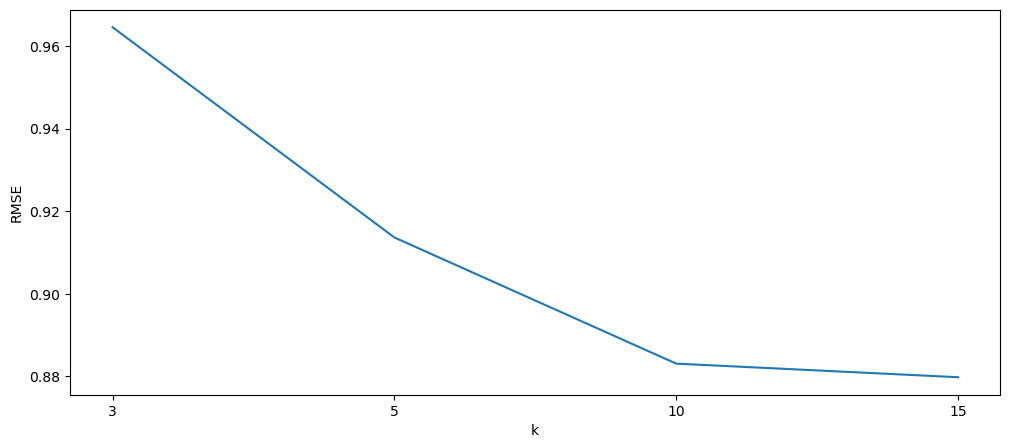

In [25]:
kS_ = [3, 5, 10, 15]
rmseS = []

for k_ in kS_:
    kS = [] # number of neighbors used in each iteration
    y_pred = []  # Create an empty list to store predictions
    y_test = []  # Create an empty list to store actual ratings

    # Loop through all the movie IDs in the test dataset
    for movie_id in tqdm(test.index): #Use tqdm to keep track of the process
        # Loop through all the user IDs in the test dataset
        for user_id in test.columns:
            # Check if the rating exists in the piv_scaled matrix
            if piv_scaled.loc[movie_id, user_id] != 0:
                k = k_  # Set the number of nearest neighbors to consider

                # Append the actual rating to y_test list
                y_test.append(piv.loc[movie_id, user_id])

                # Get the ratings of the current movie
                movie_ratings = test.loc[[movie_id]]

                # Filter the train dataset to keep only the ratings given by the current user
                train_filtered = train[train.loc[:, user_id] != 0]

                # If the number of available ratings is less than k, set k to the number of available ratings
                if len(train_filtered) < k:
                    k = len(train_filtered)
                kS.append(k)
                # Create a NearestNeighbors model using cosine similarity as the distance metric
                nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs=-1)
                nn.fit(train_filtered)  # Fit the model with the filtered train dataset

                # Get the similarities and indices of the k-nearest neighbors
                similarities, sim_indices = nn.kneighbors(movie_ratings)

                # Calculate the similarities by subtracting them from 1
                similarities = 1 - similarities[0]

                # Get the indices of the similar items
                sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index

                # Get the scores of the similar items for the current user
                sim_item_scores = piv.loc[sim_item_idx, user_id].values

                # Calculate the final predicted score by averaging the scores of the similar items
                final_score = np.mean(sim_item_scores)

                # Make sure the final score is within the rating range (1 to 5)
                if final_score < 1:
                    final_score = 1
                elif final_score > 5:
                    final_score = 5

                # Append the final predicted score to the y_pred list
                y_pred.append(final_score)
    rmse = met.mean_squared_error(y_test, y_pred, squared=False)
    rmseS.append(rmse)
    print(f"\nNumber of neighbors used in the each iteration while k={k_}: \n{pd.Series(kS).value_counts()}")
    
plt.figure(figsize = (12,5))
plt.plot([1,2,3,4], rmseS)
plt.xticks([1,2,3,4], ["3", "5", "10", "15"])
plt.xlabel("k")
plt.ylabel("RMSE")

In [26]:
rmseS

[0.9645701845088319,
 0.9136351630095133,
 0.8830674392963518,
 0.8797729672031128]

All of the neighbors has been used for each iteration. The RMSE of the test predictions is 0.8838 when using a k value of 20. However, when using a k value of 15, the performance seems to be slightly better. Now you want to determine if k=15 is a sweet spot or if the RMSE continues to decreasing with higher k values.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.30s/it]



Number of neighbors used in the each iteration while k=25: 
25    2270
16      16
18      10
24       9
20       8
23       8
19       8
22       7
21       7
17       2
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.34s/it]



Number of neighbors used in the each iteration while k=40: 
40    2148
16      16
28      12
35      12
33      11
37      11
25      11
18      10
39       9
24       9
26       9
31       9
27       8
20       8
19       8
23       8
30       7
22       7
21       7
38       7
36       6
34       5
32       4
17       2
29       1
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:32<00:00, 10.62s/it]



Number of neighbors used in the each iteration while k=60: 
60    1992
42      17
16      16
48      14
35      12
28      12
45      12
25      11
33      11
53      11
37      11
46      11
56      10
55      10
18      10
51      10
31       9
26       9
24       9
39       9
27       8
20       8
41       8
23       8
19       8
40       8
50       8
38       7
21       7
30       7
22       7
36       6
58       6
57       6
44       5
59       5
52       5
34       5
54       4
32       4
49       3
43       3
17       2
29       1
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:35<00:00, 10.78s/it]


Number of neighbors used in the each iteration while k=90: 
90    1834
42      17
16      16
69      15
48      14
      ... 
71       2
17       2
29       1
81       1
63       1
Length: 73, dtype: int64


Text(0, 0.5, 'RMSE')

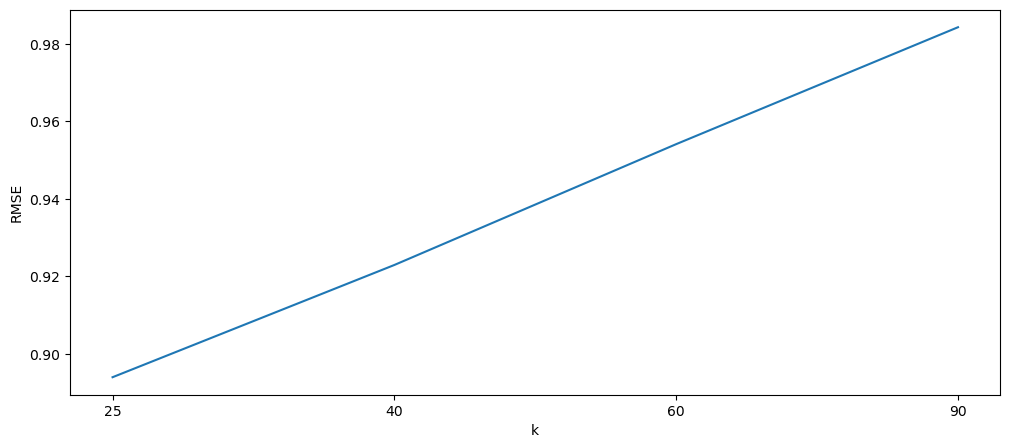

In [27]:
kS_ = [25, 40, 60, 90]
rmseS = []

for k_ in kS_:
    kS = [] # number of neighbors used in each iteration
    y_pred = []  # Create an empty list to store predictions
    y_test = []  # Create an empty list to store actual ratings

    # Loop through all the movie IDs in the test dataset
    for movie_id in tqdm(test.index): #Use tqdm to keep track of the process
        # Loop through all the user IDs in the test dataset
        for user_id in test.columns:
            # Check if the rating exists in the piv_scaled matrix
            if piv_scaled.loc[movie_id, user_id] != 0:
                k = k_  # Set the number of nearest neighbors to consider

                # Append the actual rating to y_test list
                y_test.append(piv.loc[movie_id, user_id])

                # Get the ratings of the current movie
                movie_ratings = test.loc[[movie_id]]

                # Filter the train dataset to keep only the ratings given by the current user
                train_filtered = train[train.loc[:, user_id] != 0]

                # If the number of available ratings is less than k, set k to the number of available ratings
                if len(train_filtered) < k:
                    k = len(train_filtered)
                kS.append(k)
                # Create a NearestNeighbors model using cosine similarity as the distance metric
                nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs=-1)
                nn.fit(train_filtered)  # Fit the model with the filtered train dataset

                # Get the similarities and indices of the k-nearest neighbors
                similarities, sim_indices = nn.kneighbors(movie_ratings)

                # Calculate the similarities by subtracting them from 1
                similarities = 1 - similarities[0]

                # Get the indices of the similar items
                sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index

                # Get the scores of the similar items for the current user
                sim_item_scores = piv.loc[sim_item_idx, user_id].values

                # Calculate the final predicted score by averaging the scores of the similar items
                final_score = np.mean(sim_item_scores)

                # Make sure the final score is within the rating range (1 to 5)
                if final_score < 1:
                    final_score = 1
                elif final_score > 5:
                    final_score = 5

                # Append the final predicted score to the y_pred list
                y_pred.append(final_score)
    rmse = met.mean_squared_error(y_test, y_pred, squared=False)
    rmseS.append(rmse)
    print(f"\nNumber of neighbors used in the each iteration while k={k_}: \n{pd.Series(kS).value_counts()}")
    
plt.figure(figsize = (12,5))
plt.plot([1,2,3,4], rmseS)
plt.xticks([1,2,3,4], ["25", "40", "60", "90"])
plt.xlabel("k")
plt.ylabel("RMSE")

Changing the k value seem to have an effect on the root mean square error (RMSE). In each iterations, number of neighbors used changes according to the number of neighbors. We will try a different approach.

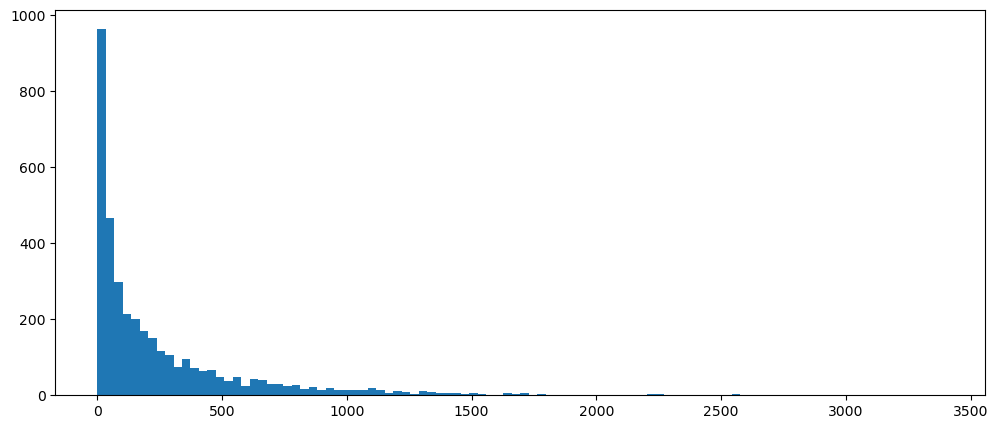

In [35]:
plt.figure(figsize = (12,5))
plt.hist(trainFinal.groupby('MovieIDs')['Ratings'].count(), bins = 100);

It appears that there are many movies that have been rated by a small number of people. A movie that has only been rated by a few users may introduce noise into the model, as these ratings may not accurately represent the movie's general appeal. The performance of k-Nearest Neighbors can indeed be sensitive to such outliers. To potentially improve the results, we can gradually remove some of these ratings. By iteratively removing these ratings, we can observe if the performance of the model improves.

We will set k = 15 for the moment.

In [38]:
counts = trainFinal.groupby('MovieIDs')['Ratings'].count()

smallerThan10 = list(counts[counts<10].index)     #Movies rated by less than 20 person
smallerThan20 = list(counts[counts<20].index)     #Movies rated by less than 20 person
smallerThan50 = list(counts[counts<50].index)     #Movies rated by less than 50 person
smallerThan100 = list(counts[counts<100].index)   #Movies rated by less than 100 person
smallerThan250 = list(counts[counts<250].index)   #Movies rated by less than 250 person

itemstToBeRemoved = [smallerThan10, smallerThan20, smallerThan50, smallerThan100, smallerThan250]

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [25:48<00:00, 309.67s/it]


Text(0, 0.5, 'RMSE')

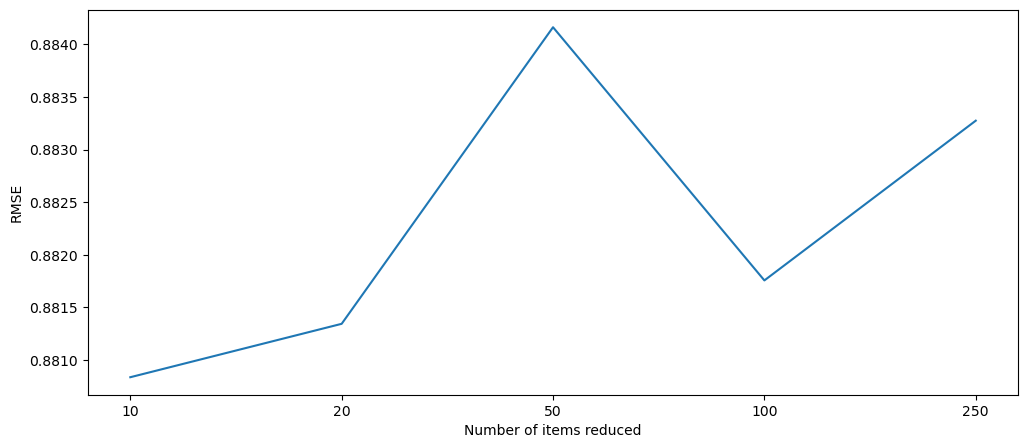

In [39]:
rmseS  = []

for removeList in tqdm(itemstToBeRemoved):
    y_pred = []
    y_test = []

    for movie_id in test.index:
        for user_id in test.columns:
            if piv_scaled.loc[movie_id, user_id] != 0:
                k = 15
                y_test.append(piv.loc[movie_id, user_id])
                movie_ratings  = test.loc[[movie_id]]
                train_filtered = train[train.loc[:, user_id] != 0]
                
                if movie_id not in removeList: #If the movie which the rating is predicted not in the removeList drop the
                        train_filtered = train_filtered.drop(removeList, axis=0, errors="ignore") #movies which are rated
                
                if len(train_filtered) < k:
                    k = len(train_filtered)

                nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs= -1)
                nn.fit(train_filtered)
                
               # Get the similarities and indices of the k-nearest neighbors
                similarities, sim_indices = nn.kneighbors(movie_ratings)

                # Calculate the similarities by subtracting them from 1
                similarities = 1 - similarities[0]

                # Get the indices of the similar items
                sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index

                # Get the scores of the similar items for the current user
                sim_item_scores = piv.loc[sim_item_idx, user_id].values

                # Calculate the final predicted score by averaging the scores of the similar items
                final_score = np.mean(sim_item_scores)

                # Make sure the final score is within the rating range (1 to 5)
                if final_score < 1:
                    final_score = 1
                elif final_score > 5:
                    final_score = 5

                # Append the final predicted score to the y_pred list
                y_pred.append(final_score)

    rmse = met.mean_squared_error(y_test, y_pred, squared=False)
    rmseS.append(rmse)
    
plt.figure(figsize = (12,5))
plt.plot([1,2,3,4,5], rmseS)
plt.xticks([1,2,3,4,5], ["10", "20", "50", "100", "250"])
plt.xlabel("Number of items reduced")
plt.ylabel("RMSE")

In [40]:
rmseS

[0.8808365432207136,
 0.8813441953166407,
 0.8841633190021679,
 0.8817566869420892,
 0.8832750421351104]

Let's try the same thing removing a smallar portion of the movies which are rated by only a small portion of the users.

In [44]:
smallerThan2 = list(counts[counts<2].index)     #Movies rated by less than 2 person
smallerThan3 = list(counts[counts<3].index)     #Movies rated by less than 3 person
smallerThan4 = list(counts[counts<4].index)     #Movies rated by less than 4 person
smallerThan5 = list(counts[counts<5].index)     #Movies rated by less than 5 person
smallerThan6 = list(counts[counts<6].index)   #Movies rated by less than 6 person
smallerThan7 = list(counts[counts<7].index)   #Movies rated by less than 7 person

itemstToBeRemoved = [smallerThan2, smallerThan3, smallerThan4, smallerThan5, smallerThan6, smallerThan7]

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [31:00<00:00, 310.12s/it]


Text(0, 0.5, 'RMSE')

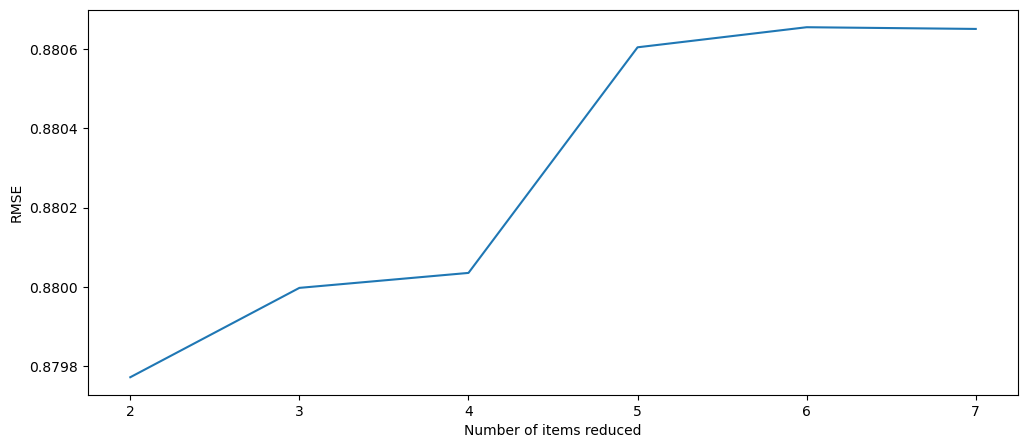

In [45]:
rmseS  = []

for removeList in tqdm(itemstToBeRemoved):
    y_pred = []
    y_test = []

    for movie_id in test.index:
        for user_id in test.columns:
            if piv_scaled.loc[movie_id, user_id] != 0:
                k = 15
                y_test.append(piv.loc[movie_id, user_id])
                movie_ratings  = test.loc[[movie_id]]
                train_filtered = train[train.loc[:, user_id] != 0]
                
                if movie_id not in removeList: #If the movie which the rating is predicted not in the removeList drop the
                        train_filtered = train_filtered.drop(removeList, axis=0, errors="ignore") #movies which are rated
                
                if len(train_filtered) < k:
                    k = len(train_filtered)

                nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs= -1)
                nn.fit(train_filtered)
               
               # Get the similarities and indices of the k-nearest neighbors
                similarities, sim_indices = nn.kneighbors(movie_ratings)

                # Calculate the similarities by subtracting them from 1
                similarities = 1 - similarities[0]

                # Get the indices of the similar items
                sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index

                # Get the scores of the similar items for the current user
                sim_item_scores = piv.loc[sim_item_idx, user_id].values

                # Calculate the final predicted score by averaging the scores of the similar items
                final_score = np.mean(sim_item_scores)

                # Make sure the final score is within the rating range (1 to 5)
                if final_score < 1:
                    final_score = 1
                elif final_score > 5:
                    final_score = 5

                # Append the final predicted score to the y_pred list
                y_pred.append(final_score)

    rmse = met.mean_squared_error(y_test, y_pred, squared=False)
    rmseS.append(rmse)
    
plt.figure(figsize = (12,5))
plt.plot([1,2,3,4,5,6], rmseS)
plt.xticks([1,2,3,4,5,6], ["2", "3","4", "5", "6", "7"])
plt.xlabel("Number of items reduced")
plt.ylabel("RMSE")

The same logic can be applied to users who have rated only a small number of movies. Users with a limited number of ratings may not provide enough information to accurately determine their preferences. Additionally, these users can introduce noise into the model and potentially skew the collaborative filtering process.

By removing these users from your dataset in an iterative manner, you can observe the impact on your model's performance.

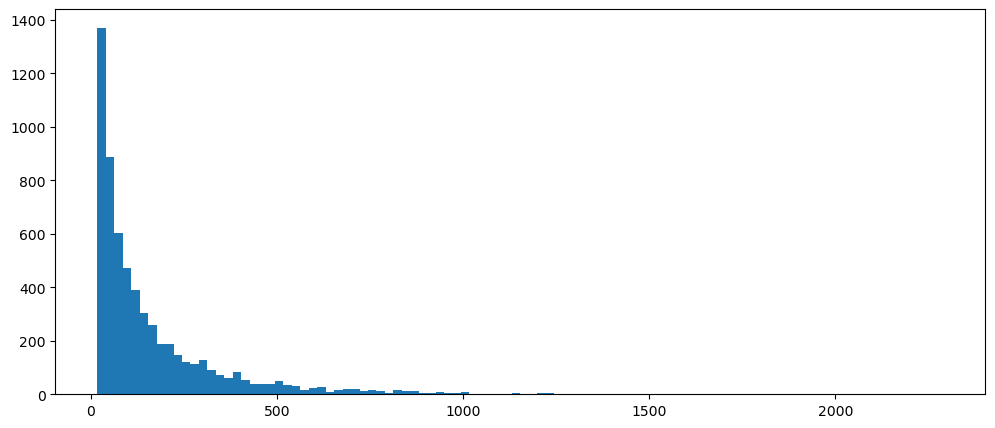

In [46]:
plt.figure(figsize = (12,5))
plt.hist(trainFinal.groupby('UserIDs')['Ratings'].count(), bins = 100);

In [47]:
counts = trainFinal.groupby('UserIDs')['Ratings'].count()

smallerThan2_user  = list(counts[counts<2].index) #Movies rated by less than 2 person
smallerThan3_user  = list(counts[counts<3].index) #Movies rated by less than 3 person
smallerThan4_user  = list(counts[counts<4].index) #Movies rated by less than 4 person
smallerThan5_user  = list(counts[counts<5].index) #Movies rated by less than 5 person
smallerThan6_user  = list(counts[counts<6].index) #Movies rated by less than 6 person
smallerThan7_user  = list(counts[counts<7].index) #Movies rated by less than 7 person
smallerThan8_user  = list(counts[counts<8].index) #Movies rated by less than 8 person
smallerThan9_user  = list(counts[counts<9].index) #Movies rated by less than 9 person

itemstToBeRemoved_user = [smallerThan2_user, smallerThan3_user, smallerThan4_user, smallerThan5_user, smallerThan6_user, smallerThan7_user, smallerThan8_user, smallerThan9_user]

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [42:45<00:00, 320.67s/it]


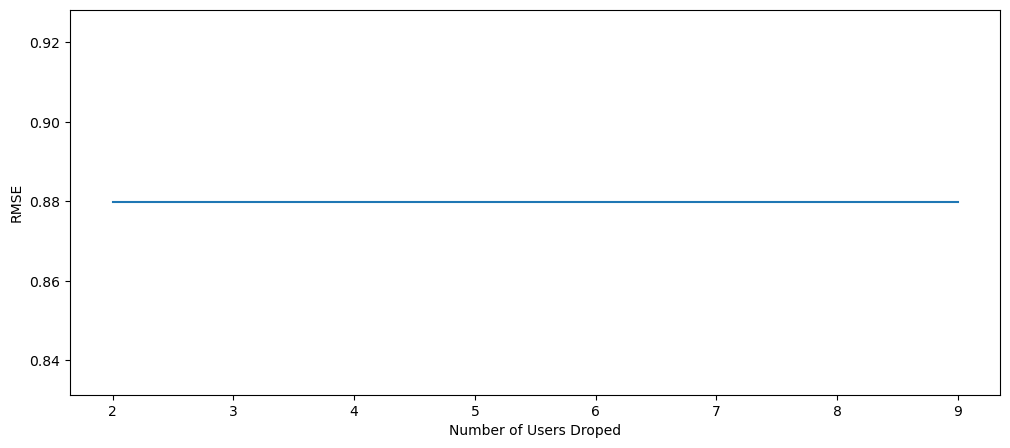

In [54]:
rmseS  = []

for removeList in tqdm(itemstToBeRemoved_user):
    y_pred = []
    y_test = []

    for movie_id in test.index:
        for user_id in test.columns:
            if piv_scaled.loc[movie_id, user_id] != 0:
                k = 15
                y_test.append(piv.loc[movie_id, user_id])
                movie_ratings  = test.loc[[movie_id]]
                train_filtered = train[train.loc[:, user_id] != 0]
                
                if movie_id not in smallerThan2:
                    train_filtered = train_filtered.drop(smallerThan2, axis=0, errors="ignore")
                
                if user_id not in removeList:
                    train_filtered = train_filtered.drop(removeList, axis=1, errors="ignore")

                if len(train_filtered) < k:
                    k = len(train_filtered)

                nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs= -1)
                nn.fit(train_filtered)

               # Get the similarities and indices of the k-nearest neighbors
                similarities, sim_indices = nn.kneighbors(movie_ratings)

                # Calculate the similarities by subtracting them from 1
                similarities = 1 - similarities[0]

                # Get the indices of the similar items
                sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index

                # Get the scores of the similar items for the current user
                sim_item_scores = piv.loc[sim_item_idx, user_id].values

                # Calculate the final predicted score by averaging the scores of the similar items
                final_score = np.mean(sim_item_scores)

                # Make sure the final score is within the rating range (1 to 5)
                if final_score < 1:
                    final_score = 1
                elif final_score > 5:
                    final_score = 5

                # Append the final predicted score to the y_pred list
                y_pred.append(final_score)

    rmse = met.mean_squared_error(y_test, y_pred, squared=False)
    rmseS.append(rmse)
    
plt.figure(figsize = (12,5))
plt.plot([2,3,4,5,6,7,8,9], rmseS)
plt.xlabel('Number of Users Droped')
plt.ylabel('RMSE')
plt.show()

In [55]:
rmseS

[0.8797729672031128,
 0.8797729672031128,
 0.8797729672031128,
 0.8797729672031128,
 0.8797729672031128,
 0.8797729672031128,
 0.8797729672031128,
 0.8797729672031128]

<div class="alert alert-block alert-info">
<h2>What Have We Learned?</h2>
<p>For this dataset:</p>
    <ul>
    <li>Using a k value between 15 and 20 tends to improve the model's performance.</li>
    <li>Excluding a small proportion of movies that have been rated only by a few users can enhance the model's performance. However, removing too many of such movies can diminish the model's effectiveness.</li>
    <li>Eliminating a small fraction of users who have rated only a few movies is not beneficial at all.</li>
    </ul>
<p>Up to this point, we have only used 20 samples for testing, and repeatedly used the same set of samples. Moving forward, we will tune the hyperparameters using different test sets with a larger test size.</p>
</div> 

In [62]:
kS = [16,17,18,19]
itemstToBeRemoved = [smallerThan2, smallerThan3, smallerThan4]
cvScores_iter = {}
rangeList = list(range(1))
for i in rangeList:
    cvScores = {}
    idx = np.random.choice(piv_scaled.index, 30)
    train = piv_scaled.drop(idx)
    test = piv_scaled.loc[idx]
    for j, removeList in enumerate(itemstToBeRemoved):
        for k_ in kS:
            y_pred = []
            y_test = []
            for movie_id in test.index:
                for user_id in test.columns:
                    if piv_scaled.loc[movie_id, user_id] != 0:
                        k = k_
                        y_test.append(piv.loc[movie_id, user_id])
                        movie_ratings  = test.loc[[movie_id]]
                        train_filtered = train[train.loc[:, user_id] != 0]

                        if movie_id not in removeList:
                            train_filtered = train_filtered.drop(removeList, axis=0, errors="ignore")

                        if len(train_filtered) < k:
                            k = len(train_filtered)

                        nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs= -1)
                        nn.fit(train_filtered)

                       # Get the similarities and indices of the k-nearest neighbors
                        similarities, sim_indices = nn.kneighbors(movie_ratings)

                        # Calculate the similarities by subtracting them from 1
                        similarities = 1 - similarities[0]

                        # Get the indices of the similar items
                        sim_item_idx = train_filtered.iloc[sim_indices[0].tolist()].index

                        # Get the scores of the similar items for the current user
                        sim_item_scores = piv.loc[sim_item_idx, user_id].values

                        # Calculate the final predicted score by averaging the scores of the similar items
                        final_score = np.mean(sim_item_scores)

                        # Make sure the final score is within the rating range (1 to 5)
                        if final_score < 1:
                            final_score = 1
                        elif final_score > 5:
                            final_score = 5
                        y_pred.append(final_score)
            str_ = f"k: {k_} & Number of Movies Removed: {j+2}"
            rmse = met.mean_squared_error(y_test, y_pred, squared=False)
            cvScores[str_] = rmse
    cvScores_iter[f"CV: {i+1}"] = cvScores

# After 2.5 hours of run time...

<Axes: >

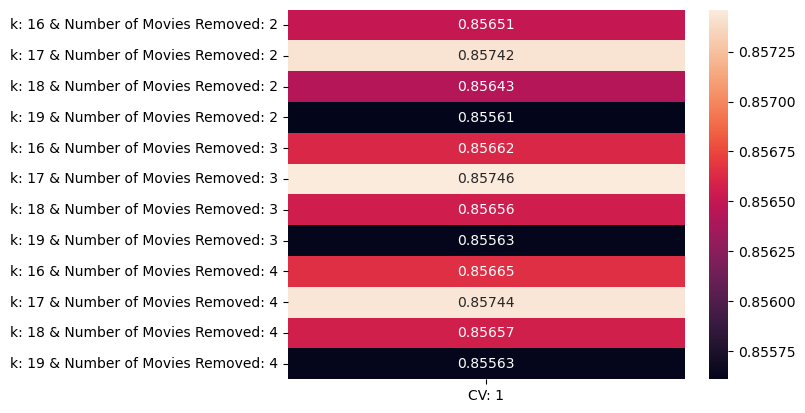

In [68]:
import seaborn as sns
df_list = []

for fold, cvScores in cvScores_iter.items():
    df = pd.DataFrame.from_dict(cvScores, orient='index', columns=[fold])
    df_list.append(df)

final_df = pd.concat(df_list, axis=1)

sns.heatmap(final_df, annot=True, fmt='.5f')

The RMSE scores observed are notably similar across the board. Under normal circumstances, it would be prudent to perform a cross-validation to further validate the robustness of our model's performance. However, given the context of this being a practice exercise, we have elected to bypass this additional validation step in the interest of time efficiency. Our next step involves testing our model on the final test set, which will give us a good indication of its practical performance capabilities.

In [79]:
testFinal.reset_index(drop=True, inplace=True)
x_test = testFinal.drop("Ratings", axis=1)
y_test = testFinal[["Ratings"]]

print(x_test.shape)
display(x_test.head())

print(y_test.shape)
display(y_test.head())

(10003, 2)


,UserIDs,MovieIDs
0,547,17
1,409,3100
2,3332,3753
3,2067,3088
4,764,1088


(10003, 1)


,Ratings
0,3
1,4
2,1
3,3
4,5


In [85]:
results = []
k = 19
idx = list(range(len(x_test)))
for i in tqdm(idx):
    user_id = x_test.iloc[i, 0]
    movie_id = x_test.iloc[i, 1]
    movie_ratings  = piv_scaled.loc[[movie_id]]
    piv_filtered = piv_scaled[piv_scaled.loc[:, user_id] != 0]
    
    if movie_id not in smallerThan2:
        piv_filtered = piv_filtered.drop(smallerThan2, axis=0, errors="ignore")

    if len(piv_filtered) < k:
        k = len(piv_filtered)

    nn = nei.NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs= -1)
    nn.fit(piv_filtered)
    similarities, sim_indices = nn.kneighbors(movie_ratings)

    # Calculate the similarities by subtracting them from 1
    similarities = 1 - similarities[0]

    # Get the indices of the similar items
    sim_item_idx = piv_filtered.iloc[sim_indices[0].tolist()].index

    # Get the scores of the similar items for the current user
    sim_item_scores = piv.loc[sim_item_idx, user_id].values

    # Calculate the final predicted score by averaging the scores of the similar items
    final_score = np.mean(sim_item_scores)

    # Make sure the final score is within the rating range (1 to 5)
    if final_score < 1:
        final_score = 1
    elif final_score > 5:
        final_score = 5
    results.append(final_score)

100%|████████████████████████████████████████████████████████████████████████████| 10003/10003 [15:44<00:00, 10.59it/s]


In [87]:
rmse = met.mean_squared_error(results, y_test.Ratings, squared=False)
rmse

0.883064459536195

The model we have created has predicted the test ratings with an RMSE of 0.88. 